# <a href="https://ramp.studio/">RAMP</a> on detecting Type 2 Diabetes in a non-invasive fashion

_Authors:_
- AMANI Alexandre
- BISCARRAT Lilian
- CHAUSSARD Alexandre
- CLERGUE Eva
- NORMAND Sophie
- SALEMBIEN Tom

# Introduction

Diabetes is a growing disease, affecting over 10% of the worldwide population. The vast majority of diabetics are type 2 diabetics (96%), that is generally characterized by a resistance to insulin, which is a molecule that enables glucose to enter the cells and provide energy. Not being able to properly consume sugar results in several complications that are all tied up to the high sugar level concentration in the blood due to not being able to consume it, resulting in possible blindness, hearth disease, infections, and so on.

Therefore, it is one today's most important challenge to properly diagnose diabetics, as short as possible to prevent complications to settle. At the moment, diabetes is diagnosed in multiple ways, one of the most secure and proper one being HbA1c measurement from blood samples. The measurement of HbA1c for a sain individual is around 5.7%, while it is said to be diabetic-like when it reaches 6.5% and more.

While this technique has proved to be really efficient in the diagnosis, it has two main downsides that we would like to tackle in this study:
- First, HbA1c is a post-disease settlement indicator, as it requires the patient to have abnormally high sugar levels over 3 months to be indicating the disease. One would rather like to be able to diagnose diabetes before it reaches that critical point.
- Second, HbA1c being a blood measurement, which is naturally invasive for the patient and some may even be really reluctant and refuse to go for a diagnosis. Also, it requires careful analysis in a medical lab, which obviously costs money.

As a result, the goal of our study is to provide a machine learning algorithm that is able to predict whether or not somebody may become diabetic in the coming time, based on blood glucose measurements from a non-invasive Continuous Glucose Monitor (CGM), as well as gathered clinical data for the patient over the duration of the study.

(explain what are the features -not too much detail, we got deeper after-, what's the CGM thingy, what's iPro, framework of the study, link to the paper, etc...)

# Getting started with the RAMP starting kit

## Software prerequisites

This starting kit requires the following dependencies:
- numpy
- pandas
- scikit-learn
- matplolib
- jupyter


## Getting the data

The data are available in the `data` source folder.

## Explore the dataset

### Clinical data

We start with an inspection of the raw clinical dataset.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from download_data import read_raw_clinical_data

X = read_raw_clinical_data()
y = X["T2DM"].values

print(f"Number of DT2 diagnosed patients: {str(y.sum()/len(y) * 100)[0]}/{len(y)}")

Number of DT2 diagnosed patients: 8/208


In [2]:
X.head()

,gender,age,BMI,glycaemia,HbA1c,T2DM
1,1,77,25.4,106,6.3,False
2,0,42,30.0,92,5.8,False
3,0,61,33.8,114,5.5,False
4,0,67,26.7,110,6.0,False
5,1,53,25.8,106,5.2,False


Features given by each column correspond to clinical observations on the patient:
- **gender** : gender of the patient (1: woman, 0: man)
- **age** : age of the patient (in years)
- **BMI** : body mass index (kg/m², weight/height²)
- **glycaemia** : basal glycaemia (mg/dL)

Looking at the gender distribution (...)

In [3]:
X["gender"].value_counts()

1    105
0    103
Name: gender, dtype: int64

etc...

We need to check for possible missing data in our samples. The following table gives the raw missing data.

In [4]:
X[X.isna().any(axis=1)].head()

,gender,age,BMI,glycaemia,HbA1c,T2DM
68,0,71,27.9,109,NaN,False
91,1,72,NaN,96,5.7,False
94,1,53,43.9,82,NaN,False
95,1,61,35.3,102,NaN,False
96,0,48,21.2,105,NaN,False


Since we would like not to use the HbA1c as it's a blood measurement, the one missing entry that we have to impute is the BMI.

#### BMI: One missing value

Looking at the overall clinical data, we notice that we have a unique missing value for a BMI entry.

In [5]:
X[X["BMI"].isna()].head()

,gender,age,BMI,glycaemia,HbA1c,T2DM
91,1,72,NaN,96,5.7,False


We propose different approaches to fill the BMI missing value.

##### Method 1: Imputation using the mean, with handcrafted prior

We impute the missing value of the feature BIM by the average BIM of individuals of the same age and gender (handcrafted prior). 

As we can see on the following table, we do have some very similar individuals to enable us to safely determine the missing value. Luckily, we also have that the missing value entry has the same type 2 diabetes diagnosis of the others, which may be an additional prior item to compliment our imputation using the mean. 

In [6]:
X[(X["age"]==72) & (X["gender"]==1)]

,gender,age,BMI,glycaemia,HbA1c,T2DM
9,1,72,35.6,106,6.2,False
91,1,72,NaN,96,5.7,False
148,1,72,29.0,105,NaN,False


Note that this approach is biased by the handcrafted prior we took. For instance, the HbA1c measurement of the entry `91` is much lower than the one used for imputation for the entry `9`. That indicates that the sugar level of the entry `91` is more controlled than `9`, specifically with an HbA1c around `5.5% < 6.2%`, which could be correlated with a carbohydrate limited alimentation for entry `91`. Therefore, the BMI could even be lowered if that reasoning proved to be true.  

Tthe result of this handcrafted prior using the mean gives us an imputed value of **32.3**.

In [7]:
df = X[(X["age"]==72) & (X["gender"]==1)]

print(f'BMI average value (over all samples): {X["BMI"].mean()}')
print(f'Imputed value (mean with handcrafted prior): {df["BMI"].mean()}')

X_imputed_mean = X.fillna(value={"BMI":df["BMI"].mean()})
X_imputed_mean.loc[91]

BMI average value (over all samples): 29.993236714975847
Imputed value (mean with handcrafted prior): 32.3


gender           1
age             72
BMI           32.3
glycaemia       96
HbA1c          5.7
T2DM         False
Name: 91, dtype: object

##### Method 2: Multiple Imputation with Scikit-learn IterativeImputer

The IterativeImputer models each feature with missing values as a function of other features, and uses that estimate for imputation. It does so in an iterated round-robin fashion: at each step, a feature column is designated as output y and the other feature columns are treated as inputs X. A regressor is fit on (X, y) for known y. Then, the regressor is used to predict the missing values of y.

The imputed BMI value using that approach is **31.1**, which is slightly lower than the previous result, which may underpin the limits of our handcrafted prior.

In [8]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pandas as pd


print(f'BMI average value (over all samples): {X["BMI"].mean()}')

imp = IterativeImputer(max_iter=10, random_state=0)
X_imputed = pd.DataFrame(imp.fit_transform(X), columns=X.columns)

print(f'Imputed value using IterativeImputer: {X_imputed["BMI"].loc[91]}')

X_imputed.loc[91]

BMI average value (over all samples): 29.993236714975847
Imputed value using IterativeImputer: 31.1


gender        0.0
age          64.0
BMI          31.1
glycaemia    89.0
HbA1c         6.1
T2DM          1.0
Name: 91, dtype: float64

##### Method 3: Multiple Imputation with Scikit-learn KNN Imputer

The KNNImputer class provides imputation for filling in missing values using the k-Nearest Neighbors approach. By default, an euclidean distance metric that supports missing values, nan_euclidean_distances, is used to find the nearest neighbors. Each missing feature is imputed using values from n_neighbors nearest neighbors that have a value for the feature. The feature of the neighbors are averaged uniformly or weighted by distance to each neighbor.


The imputed BMI value is **31.1**, same as the iterative imputer.

In [9]:
from sklearn.impute import KNNImputer

print(f'BMI average value (over all samples): {X["BMI"].mean()}')

imputer = KNNImputer(n_neighbors=2, weights="uniform")
X_imputed_knn = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

print(f'Imputed value using KNNImputer: {X_imputed_knn["BMI"].loc[91]}')

X_imputed_knn.loc[91]

BMI average value (over all samples): 29.993236714975847
Imputed value using KNNImputer: 31.1


gender        0.0
age          64.0
BMI          31.1
glycaemia    89.0
HbA1c         6.1
T2DM          1.0
Name: 91, dtype: float64

##### Conclusion on BMI missing value

Looking at the previous results, we will assume that the handcrafted prior is not relevant enough to estimate the missing value. Since we believe in a better interpolation offered by the iterative imputer, we will stick to that one to fill the one BMI missing value.

#### Univariate statistics on the clinical data

We can note in the following descriptive statistics table that we have approximately the same number of men and women in our dataset. The patients are almost 60 years old in mean (the youngest is 29, the older, 88). 50% of them have a body mass index inferior to 29, the values varying between 18 and 48. For glycaemia, the mean is around 100mg/dL, with a minimum at 78 and a maximum at 135.

In [10]:
X.describe()

,gender,age,BMI,glycaemia,HbA1c
count,208.000000,208.000000,207.000000,208.000000,200.000000
mean,0.504808,59.600962,29.993237,100.581731,5.763500
std,0.501183,10.094692,4.738661,11.407814,0.295558
min,0.000000,29.000000,18.100000,78.000000,5.100000
25%,0.000000,54.000000,27.000000,92.000000,5.600000
50%,1.000000,61.000000,29.300000,101.000000,5.800000
75%,1.000000,66.000000,32.400000,108.000000,6.000000
max,1.000000,88.000000,48.700000,135.000000,6.500000


In [11]:
X['gender'].value_counts()

1    105
0    103
Name: gender, dtype: int64

<AxesSubplot: ylabel='glycaemia'>

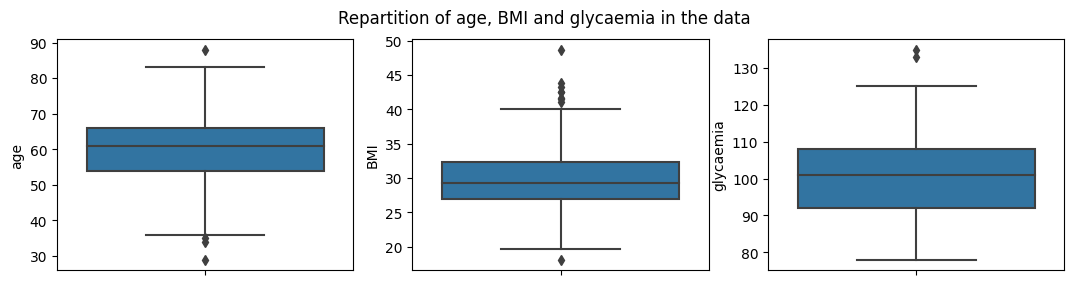

In [12]:
plt.figure(figsize=(13,3))
plt.suptitle("Repartition of age, BMI and glycaemia in the data")
plt.subplot(1,3,1)
sns.boxplot(data=X, y="age")
plt.subplot(1,3,2)
sns.boxplot(data=X, y="BMI")
plt.subplot(1,3,3)
sns.boxplot(data=X, y="glycaemia")

_Remark:_

the body mass index is often interpreted with the following range of values : underweight (under 18.5 kg/m2), normal weight (18.5 to 24.9), overweight (25 to 29.9), and obese (30 or more). According to our data, the analysed patients are mostly in overweight.
the value of glycaemia depends strongly on the moment of measurement (be fasting or having eaten before the measurement). A basal glycaemia (be fasting) is considered normal between 70 and 110mg/dL (approximately what we observe on our data, which is consistent with the high number of non-diabetic patients in our data).

In [13]:
X['T2DM'].value_counts()

False    191
True      17
Name: T2DM, dtype: int64

_Label variable_: 1 if the patient has been diagnosed type 2 diabetic / 0 if not

As we can see, our dataset is clearly desequilibrated, with a low number of diagnosed diabetic patients.

#### Bivariate statistics

We can study the correlation visually between variables, distinguishing with colors diabetic vs non-diabetic patients.

The following visualisation needs to be taken carefully when analysing the histograms, as we only have 17 diabetic patients (label 1). We observe a low correlation between variables, confirmed by the values of the correlation matrix.

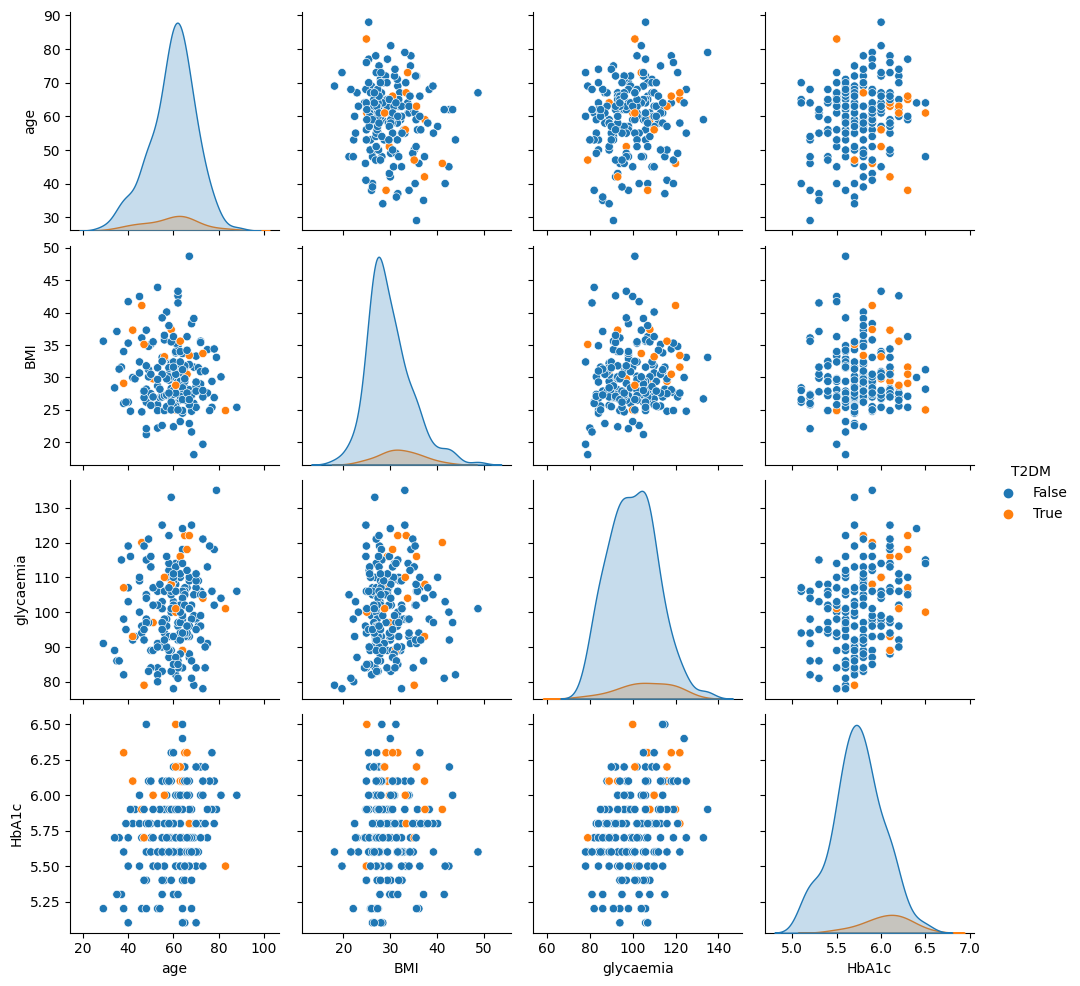

In [14]:
sns.pairplot(data=X.iloc[:,1:], hue="T2DM")

<AxesSubplot: title={'center': 'Correlation matrix'}>

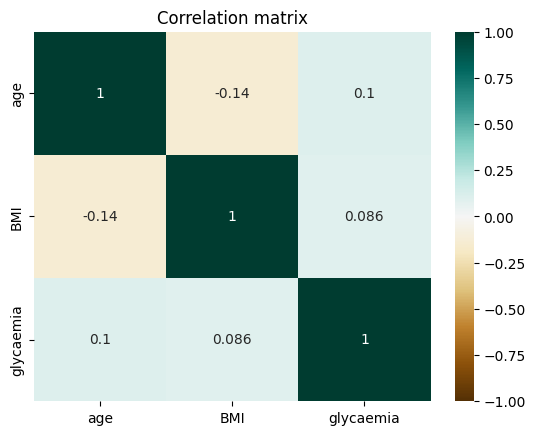

In [15]:
plt.title("Correlation matrix")
sns.heatmap(data=X.iloc[:,1:4].corr(), vmin=-1, vmax=1, cmap="BrBG", annot=True)

#### Focus on the HbA1c

The typical diagnosis of diabetes is done through HbA1c blood measurement, which characterizes the glucose value over 3 month. The threshold of 6.5% characterizes diabetic people according to most clinical procedures.

One can import the HbA1c measurements of the individual in our dataset. A statistical study is then proceeded.

In [16]:
from download_data import read_raw_clinical_data

def get_HbA1c_and_labels_data(path='.'):
    # First we fetch the clinical data
    clinical_data = read_raw_clinical_data(path)
    # Then we output the HbA1c and the labels dataframe, for each user, may it be missing or not
    return clinical_data[["HbA1c", "T2DM"]]

df_hba1c = get_HbA1c_and_labels_data()
df_hba1c.head()

,HbA1c,T2DM
1,6.3,False
2,5.8,False
3,5.5,False
4,6.0,False
5,5.2,False


In [17]:
df_hba1c["HbA1c"].corr(df_hba1c["T2DM"])

0.2928152867862463

<AxesSubplot: xlabel='T2DM', ylabel='HbA1c'>

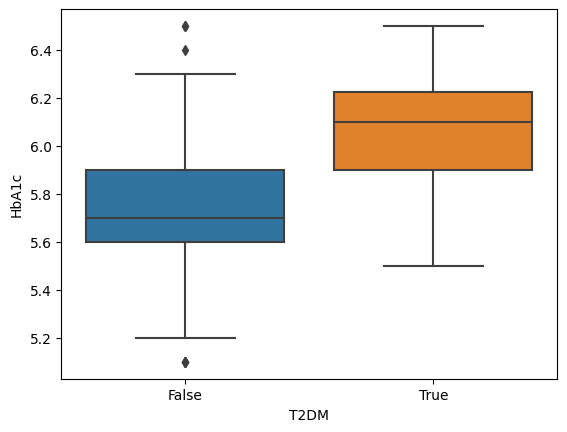

In [18]:
import seaborn as sns

sns.boxplot(data=df_hba1c, x="T2DM", y = "HbA1c")

Why it doesn't work ? Probably coz the blood measurement is far before the diagnosis has been set, check the paper

<AxesSubplot: title={'center': 'Boxplot of HbA1c for diabetic and non diabetic patients'}, xlabel='T2DM', ylabel='HbA1c'>

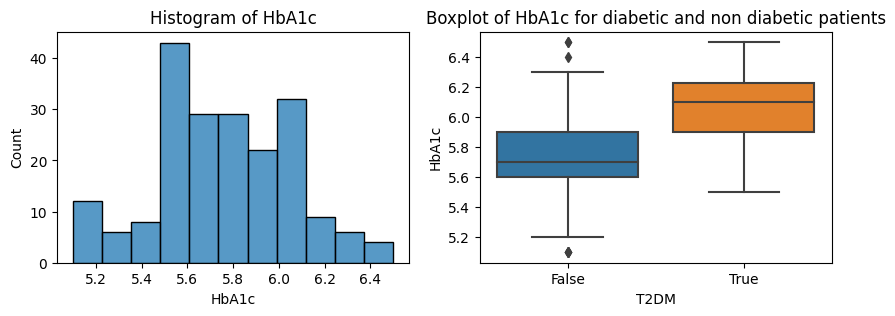

In [19]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.title("Histogram of HbA1c")
sns.histplot(data=df_hba1c, x="HbA1c")
plt.subplot(1,2,2)
plt.title("Boxplot of HbA1c for diabetic and non diabetic patients")
sns.boxplot(data=df_hba1c, x="T2DM", y="HbA1c")

As expected, the repartition of HbA1c values is different whether the patient is diabetic or not.

Since the HbA1c is a blood measurement, we would like to get rid of it to avoid invasive procedures. Instead, we will focus on predicting T2DM states with non invasive CGM extracted features in addition to the clinical entries.

#### CGM Data

Now, we dive into the glucose monitored data. These are taken by the CGM iPro sensor (see link, blablabla).

Let's import one of the users raw CGM data so we can have a look.

<AxesSubplot: >

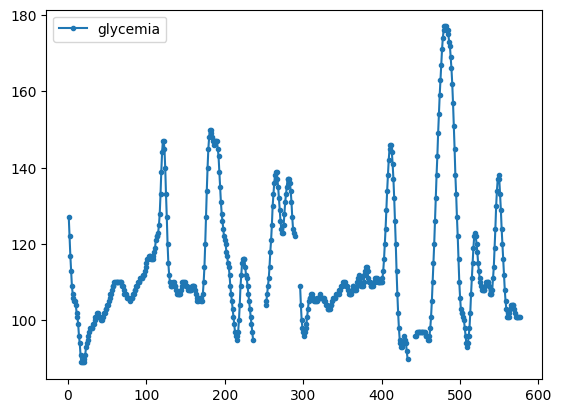

In [20]:
from download_data import get_cgm_data as get_raw_cgm_data

raw_cgm_data = get_raw_cgm_data(6)
raw_cgm_data.plot(marker='.', linestyle='-')

##### Interpolation of the Continuous Glucose values

As we can see on the previous curve, we might have some situations in which the CGM is not capturing the blood sugar value for various reasons (disconnection, high pressure on the measurement area, out of measurement area, ...).

Interpolation is a method widely used to estimate missing CGM data by predicting values that would have been recorded if the sensor had not failed (see https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3692219/).

There are several methods for interpolation of missing CGM data, but the choice of method depends on the nature of the data and the goals of the analysis. For our application, we use the Linear interpolation method that has been accepted by the medical community through multiple grid systems (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2903980/). This method estimates missing values by connecting the neighboring observed values with a straight line. It assumes that the glucose values change linearly over time, which is also widely verified by short term linear forecasting of blood glucose models that are able to achieve impressive accuracy (15 minutes being a short range for instance).

Some other commonly used interpolation methods are:

- The cubic spline interpolation: This method estimates missing values by fitting a smooth curve to the observed data using cubic polynomials. Cubic spline interpolation assumes that the glucose values change smoothly over time.

- The Kalman filter: This method estimates missing values by using a mathematical model that predicts the glucose values based on the observed data and the known properties of the system. Kalman filter interpolation assumes that the glucose values follow a stochastic process. This method has been widely in used recently to interpolate Glucose data.

<AxesSubplot: >

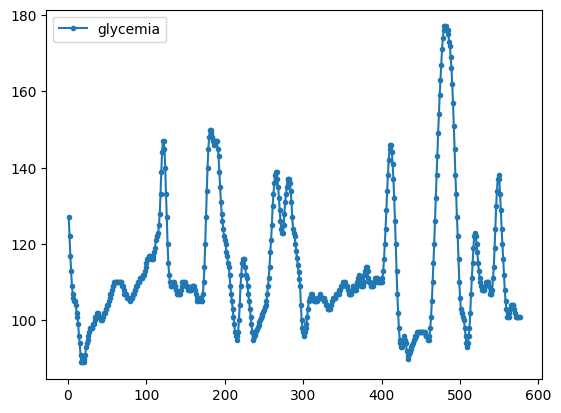

In [21]:
cgm_data_interp = raw_cgm_data.interpolate(method="linear")
cgm_data_interp.plot(marker='.', linestyle='-')

##### Statistics and handcrafted feature extraction on the CGM data

The interpolation is preprocessed when running the `download_data.py` script that generates the `external_data.csv` file, which contains preprocessed CGM time series of each person in the dataset.

These time series are either of length 48h or 24h, depending on how long the sensor was attached to the patient. For simpler data management, the `external_data.csv` contains the dataframe of the time series of with `NaN` values after 24h length if no data is recorded.

<AxesSubplot: >

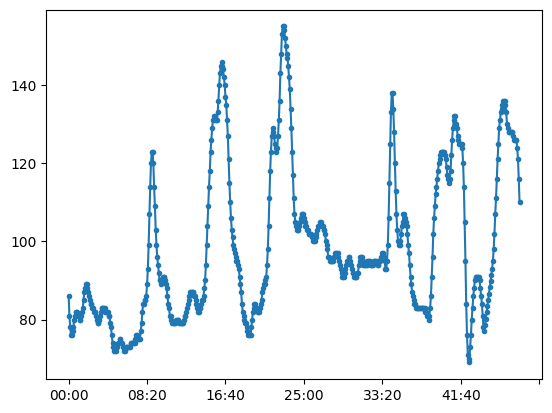

In [22]:
def get_cgm_data(path='./'):
    data = pd.read_csv('external_data.csv')
    data.set_index('patient_id', inplace=True)
    return data

def get_patient_cgm_data(patient_id, path='./'):
    cgm_data = get_cgm_data(path)
    patient_cgm = cgm_data.loc[patient_id]
    patient_cgm.dropna(inplace=True)
    return patient_cgm

cgm_data = get_patient_cgm_data(1)
cgm_data.plot(label='glycemia', marker='.')

Let's count how many of these time series are only 24h long, and see to which individual they belong to.

In [23]:
all_cgm_data = get_cgm_data()
nan_cgm_rows = all_cgm_data[all_cgm_data.isna().any(axis=1)]

print(f'Number of 24h long time series: {len(nan_cgm_rows)}/{len(all_cgm_data)}')

nan_entries_diabetics = y[nan_cgm_rows.index - 1]

print(f'Number of diabetics among these: {nan_entries_diabetics.sum()}/{len(nan_entries_diabetics)}')

Number of 24h long time series: 17/208
Number of diabetics among these: 0/17


Let's try making some interesting statistics on these time series, so we can extract relevant features that characterizes well diabetics.

<AxesSubplot: xlabel='label', ylabel='cgm_max'>

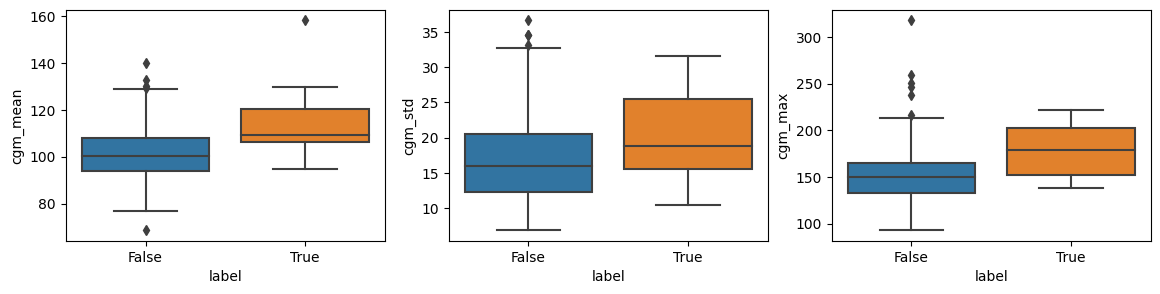

In [24]:
stats = pd.DataFrame(index=all_cgm_data.index)

stats["label"] = y[all_cgm_data.index - 1]
stats["cgm_mean"] = list(all_cgm_data.mean(axis=1))
stats["cgm_max"] = list(all_cgm_data.max(axis=1))
stats["cgm_std"] = list(all_cgm_data.std(axis=1))

plt.figure(figsize=(14,3))
plt.subplot(1,3,1)
sns.boxplot(data=stats, x='label', y="cgm_mean")
plt.subplot(1,3,2)
sns.boxplot(data=stats, x='label', y="cgm_std")
plt.subplot(1,3,3)
sns.boxplot(data=stats, x='label', y="cgm_max")

We can see that descriptive statistics of the CGM time series could be use for differenciation between diabetic and non diabetic patients. Diabetic patients tend to have a higher mean of glucose value during the day, and reach higher maximum than non diabetic people, being a symptom of the disease.

We can implement a large variety of metrics to analyse this CGM data. It could be interesting to understand the time spent by patients in hyperglycemia or normal range, as a percentage of a day for example. The following functions allow to consider the proportion of the day spent by the patient in the normal interval glycemia and above.

<AxesSubplot: xlabel='label', ylabel='time_in_hyperglycemia'>

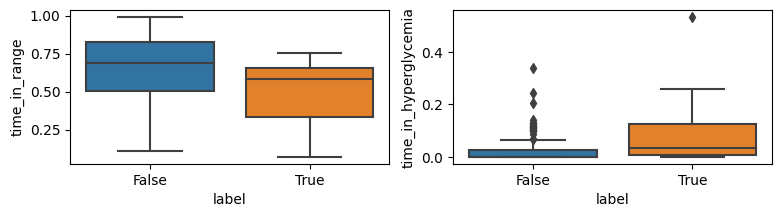

In [25]:
def compute_average_time_in_range(cgm_val, normal_range=[70, 110]):
    col_in_range = cgm_val[(cgm_val >= normal_range[0]) & (cgm_val <= normal_range[1])]
    return len(col_in_range)/len(cgm_val)

def compute_average_time_above(cgm_val, value=150):
    col_above = cgm_val[(cgm_val > value)]
    return len(col_above)/len(cgm_val)

stats["time_in_range"] = all_cgm_data.apply(compute_average_time_in_range, axis=1)
stats["time_in_hyperglycemia"] = all_cgm_data.apply(compute_average_time_above, axis=1)

plt.figure(figsize=(14,2))
plt.subplot(1,3,1)
sns.boxplot(data=stats, x='label', y="time_in_range")
plt.subplot(1,3,2)
sns.boxplot(data=stats, x='label', y="time_in_hyperglycemia")

We can also compute other features on CGM time series, such as the area under the CGM curve on 24h, the skewness, or different percentiles (here 3rd quartile).

<AxesSubplot: xlabel='label', ylabel='Q3'>

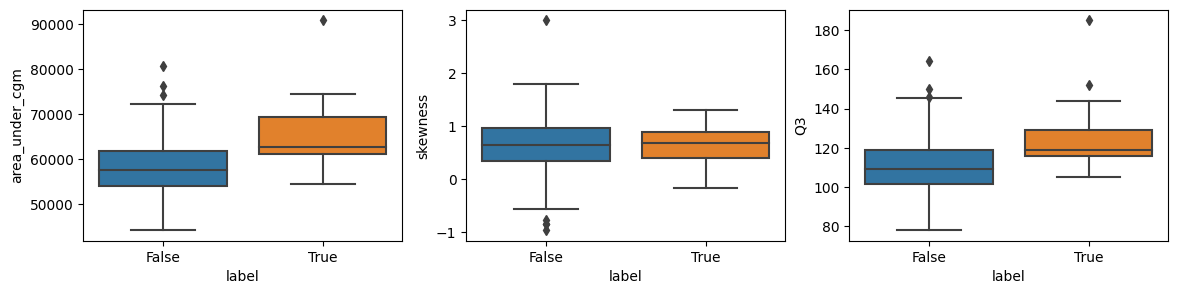

In [26]:
from numpy import trapz
stats["area_under_cgm"] = all_cgm_data.apply(trapz, axis=1)
stats["skewness"] = list(all_cgm_data.skew(axis=1))
stats["Q3"] = list(all_cgm_data.quantile(0.75, axis=1))

plt.figure(figsize=(14,3))
plt.subplot(1,3,1)
sns.boxplot(data=stats, x='label', y="area_under_cgm")
plt.subplot(1,3,2)
sns.boxplot(data=stats, x='label', y="skewness")
plt.subplot(1,3,3)
sns.boxplot(data=stats, x='label', y="Q3")

We can also try to consider the glucose level at different times of the day (NB : the first value corresponds to the one measured at midnight for the first day). We can for example consider windows of 8 hours (to divide 24 hours in 3).

So we can compute these features in our pipeline, we would put them into a wrapper of functions in our notebook. In practice, these functions are implemented in the `estimator.py` within the `FeatureExtractor`.

In [27]:
def compute_variance(cgm_data):
    return cgm_data.var()

def compute_mean(cgm_data):
    return cgm_data.mean()

def compute_average_time_in_range(cgm_data, normal_range=[70, 127]):
    index_in_range = cgm_data[(cgm_data >= 70) & (cgm_data <= 127)].index
    return len(index_in_range)/len(cgm_data.index)

def compute_maximum(cgm_data):
    return cgm_data.max()

additional_features = {
    "CGM Variance":compute_variance,
    "CGM Mean": compute_mean,
    "CGM Time in range": compute_average_time_in_range,
    "CGM Maximum": compute_maximum,
}

print("Extracted features:")
for name, fun in additional_features.items():
    print(f'  * {name}: {fun(cgm_data)}')

Extracted features:
  * CGM Variance: 385.6137850241557
  * CGM Mean: 98.42013888888889
  * CGM Time in range: 0.8802083333333334
  * CGM Maximum: 155.0


These new features regarding the patients are part of the data exploration we can do on the CGM time series, to finally determine whether the patient is going to be DT2 or not in addition to the clinical data.

Other suggestions could be implemented: looking at postprandial overall values (that would use more of the time serie structure), night mean value, day mean value, day variance, etc...

##### Deep crafted features

Time series analysis has always been challenging, as the complexity of the entries and the characteristics are often difficult to unveil and analyse. Previously, we have been trying to extract relevant features through medical knowledge we have on type 2 diabetes. However, it is very likely that we couldn't grasp every relevant insights on the data ourselves.

To attend that issue, we propose to extract relevant features using CNN architectures that have proven their efficiency on multiple tasks for time series analysis (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9040363/). The specific architecture we have in mind, is to build a latent space of given dimension from which will extract features. This can namely be achieved by Auto-encoder architectures, or Variational Auto-Encoders.

The idea of these 2 architectures is to build a first model (CNN in our case), that is called the encoder, which pushes the data into a latent space of our design. Then, we have a decoder (another CNN) that takes the data from the latent space to rebuild the original data. Once that model (encoder + decoder) is well trained, we can take only the encoder part to build latent features that might be useful for our analysis.

## Building predictive models

First we fetch the training and testing sets

In [29]:
from problem import get_train_data, get_test_data

X_train, y_train = get_train_data()
X_test, y_test = get_test_data()

For submitting to the [RAMP site](https://ramp.studio), you will need to create a `estimator.py` file that defines a `get_estimator` function which returns a scikit-learn estimator.

The initial example classifier in your sandbox is:

In [30]:
import sklearn.preprocessing as preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Functions to fetch the CGM data and plug new features in the dataset taken from the series
def get_cgm_data():
    data = pd.read_csv('external_data.csv')
    data.set_index('patient_id', inplace=True)
    return data

def get_patient_cgm_data(patient_id):
    cgm_data = get_cgm_data()
    patient_cgm = cgm_data.loc[patient_id]
    patient_cgm.dropna(inplace=True)
    return patient_cgm

def add_cgm_feature(clinical_data, feature_name, compute_feature_function):
    n_individuals = len(clinical_data)
    feature_column = np.zeros((n_individuals,))

    for i, user_id in enumerate(clinical_data.index.values):
        cgm_data = get_patient_cgm_data(int(user_id))
        feature = compute_feature_function(cgm_data)
        feature_column[i] = feature

    clinical_data[feature_name] = feature_column
    return clinical_data

# Wrapper for the feature extraction
class FeatureExtractor:
    
    def __init__(self):
        pass
    
    def fit(self, X, y):
        return self
    
    def transform(self, X):
        for name, fun in additional_features.items():
            X = add_cgm_feature(X, name, fun)
        return X

# Minimal preprocessing of the data
def get_preprocessing():
    return preprocessing.StandardScaler(), preprocessing.MinMaxScaler()
            
def get_estimator():
    
    feature_extractor = FeatureExtractor()
    
    classifier = RandomForestClassifier(
        n_estimators=50, random_state=61
    )
    
    pipe = make_pipeline(
        feature_extractor,
        *get_preprocessing(),
        classifier
    )
    
    return pipe

In [31]:
feature_extractor = FeatureExtractor()
feature_extractor.transform(X_train)

,gender,age,BMI,glycaemia,CGM Variance,CGM Mean,CGM Time in range,CGM Maximum
patient_id,,,,,,,,
57,1.0,62.0,34.9,84.0,202.075314,98.090278,0.961806,153.0
201,0.0,70.0,27.9,111.0,58.625868,105.279514,0.993056,128.0
56,0.0,46.0,41.1,120.0,152.851196,112.364583,0.887153,152.0
76,0.0,38.0,34.0,98.0,279.174538,101.432292,0.907986,153.0
19,1.0,59.0,32.2,89.0,174.381894,93.698785,0.961806,131.0
...,...,...,...,...,...,...,...,...
67,0.0,58.0,27.0,114.0,124.931002,94.892361,0.998264,128.0
177,0.0,48.0,31.8,97.0,542.006908,111.006944,0.809028,172.0
113,0.0,67.0,27.0,96.0,480.467198,98.423611,0.873264,163.0


When developing locally, you can use `scikit-learn` tools to test a given model.

In [32]:
from sklearn.model_selection import cross_val_score
from problem import get_cv

cv = get_cv(X_train, y_train)
cross_val_score(get_estimator(), X_train, y_train, cv=cv)

array([0.92857143, 0.92857143, 0.92857143, 0.89285714, 0.92592593,
       0.92857143, 0.92857143, 0.89285714, 0.89285714, 0.92592593,
       0.89285714, 0.92857143, 0.92857143, 0.89285714, 0.92592593])

You could easily train an test a model and the respective datasets.

In [33]:
model = get_estimator()
model.fit(X_train, y_train)

y_true = y_test
y_pred = model.predict(X_test)

In [34]:
import sklearn.metrics as metrics

metrics_list = {
    "Balanced Accuracy":metrics.balanced_accuracy_score, 
    "F1":metrics.f1_score, 
    "Precision":metrics.precision_score, 
    "Recall":metrics.recall_score
}

for name, metric in metrics_list.items():
    print(f"* {name}: {metric(y_true, y_pred)}")

print("Confusion matrix")
metrics.confusion_matrix(y_true, y_pred)

* Balanced Accuracy: 0.5753968253968254
* F1: 0.25
* Precision: 0.5
* Recall: 0.16666666666666666
Confusion matrix


array([[62,  1],
       [ 5,  1]], dtype=int64)

In [35]:
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


# Submission

To submit your code, you can refer to the [online documentation](https://paris-saclay-cds.github.io/ramp-docs/ramp-workflow/stable/using_kits.html)